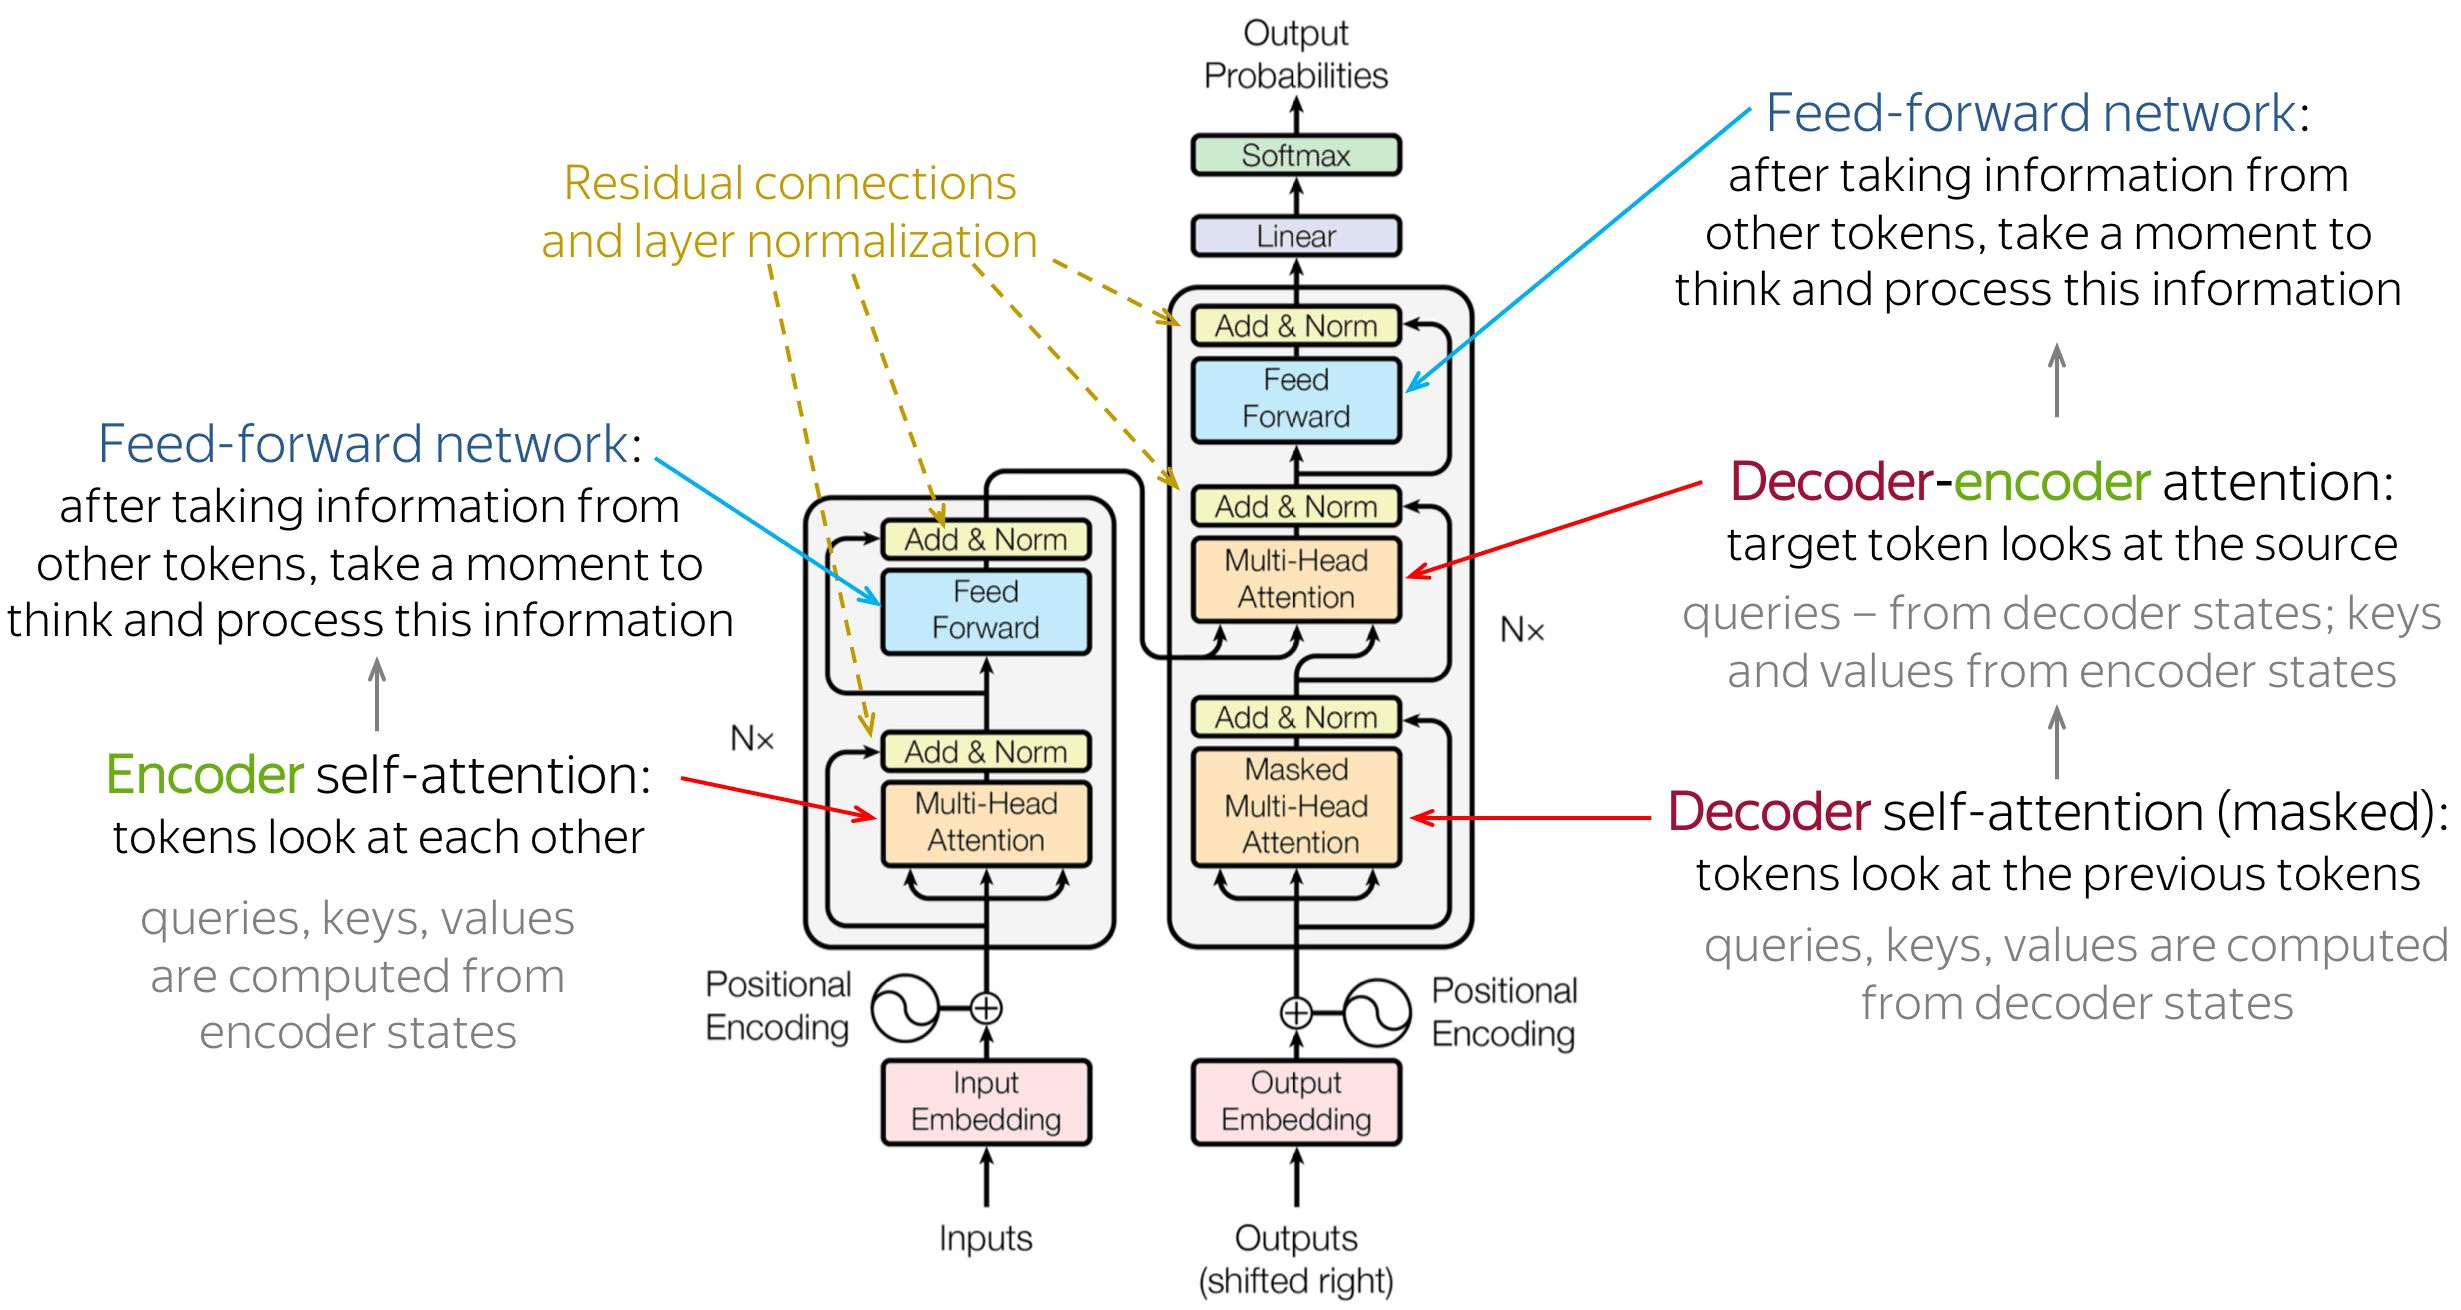

#### Step 1: Import Required Libraries

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from transformers import AutoTokenizer

#### Step 2: Multi-Head Attention Module

In [3]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads
        assert d_model % num_heads == 0

        self.q_linear = nn.Linear(d_model, d_model)
        self.k_linear = nn.Linear(d_model, d_model)
        self.v_linear = nn.Linear(d_model, d_model)
        self.out_linear = nn.Linear(d_model, d_model)

    def forward(self, query, key, value, mask=None):
        batch_size = query.size(0)
        print("\n[MultiHeadAttention] Input shape:", query.shape)

        Q = self.q_linear(query).view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)
        K = self.k_linear(key).view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)
        V = self.v_linear(value).view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)

        print("[MultiHeadAttention] Q, K, V shape:", Q.shape, K.shape, V.shape)

        scores = torch.matmul(Q, K.transpose(-2, -1)) / (self.head_dim ** 0.5)
        if mask is not None:
            scores = scores.masked_fill(mask == 0, float('-inf'))
        attn = F.softmax(scores, dim=-1)
        context = torch.matmul(attn, V)

        context = context.transpose(1, 2).contiguous().view(batch_size, -1, self.d_model)
        out = self.out_linear(context)
        print("[MultiHeadAttention] Output shape:", out.shape)
        return out

#### Step 3: Positionwise Feedforward Network

In [4]:
class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super().__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        print("[FeedForward] Input shape:", x.shape)
        out = self.linear2(self.dropout(F.relu(self.linear1(x))))
        print("[FeedForward] Output shape:", out.shape)
        return out

#### Step 4: Encoder Layer

In [5]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.ffn = PositionwiseFeedForward(d_model, d_ff, dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        print("\n[EncoderLayer] Input shape:", x.shape)
        attn_out = self.self_attn(x, x, x, mask)
        x = self.norm1(x + self.dropout(attn_out))
        ffn_out = self.ffn(x)
        x = self.norm2(x + self.dropout(ffn_out))
        print("[EncoderLayer] Output shape:", x.shape)
        return x

#### Step 5: Transformer Encoder


```python
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()
```
- Initializes the PyTorch module.
- `d_model`: the dimensionality of the input and output embeddings.
- `num_heads`: number of heads in the multi-head attention.
- `d_ff`: hidden layer size in the feedforward network.
- `dropout`: for regularization.

---

```python
        self.self_attn = MultiHeadAttention(d_model, num_heads)
```
- Defines a **self-attention block** using multi-head attention.
- This will let each token in the input attend to **all other tokens** in the same sequence.

---

```python
        self.ffn = PositionwiseFeedForward(d_model, d_ff, dropout)
```
- This is a feed-forward network applied **independently to each position** in the sequence.
- Helps with non-linear transformation of information after attention.

---

```python
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
```
- Layer Normalization layers are used after each sublayer (attention and feedforward).
- Help stabilize and speed up training.

---

```python
        self.dropout = nn.Dropout(dropout)
```
- Dropout is applied after attention and feedforward layers for regularization.

---

### Forward Pass Logic

```python
    def forward(self, x, mask=None):
        print("\n[EncoderLayer] Input shape:", x.shape)
```
- `x`: the input tensor of shape `[batch_size, seq_len, d_model]`.
- `mask`: optional mask to avoid attending to padding tokens.
- Print helps trace the tensor shape going in.

---

```python
        attn_out = self.self_attn(x, x, x, mask)
```
- Applies **self-attention** with `Q = K = V = x`.
- Output is a tensor of shape `[batch_size, seq_len, d_model]` where tokens have interacted.

---

```python
        x = self.norm1(x + self.dropout(attn_out))
```
- Adds residual connection (`x + attn_out`) and applies dropout and normalization.
- Keeps original information and stabilizes training.

---

```python
        ffn_out = self.ffn(x)
```
- Passes result through positionwise feedforward network.

---

```python
        x = self.norm2(x + self.dropout(ffn_out))
        print("[EncoderLayer] Output shape:", x.shape)
```
- Again, uses a residual connection (`x + ffn_out`), dropout, and layer norm.
- Final output shape is printed.

---

### 🔁 Summary of Data Flow:
1. Input → Self-Attention → Add & Norm → Feedforward → Add & Norm → Output
2. Each token becomes **context-aware**, enriched with information from all other tokens.

In [6]:
class TransformerEncoder(nn.Module):
    def __init__(self, num_layers, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()
        self.layers = nn.ModuleList([
            EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)
        ])
        self.norm = nn.LayerNorm(d_model)

    def forward(self, x, mask=None):
        print("\n[Encoder] Input shape:", x.shape)
        for i, layer in enumerate(self.layers):
            print(f"[Encoder] Layer {i+1}")
            x = layer(x, mask)
        x = self.norm(x)
        print("[Encoder] Final output shape:", x.shape)
        return x

#### Step 6: Decoder Layer

### 1. **Class Initialization** (`__init__` method):
```python
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()
```
- Initializes the `DecoderLayer` as a subclass of `nn.Module`.
- `d_model`, `num_heads`, `d_ff`, and `dropout` are parameters that define the size of the model, the number of attention heads, the feedforward network size, and dropout rate respectively.

---

### 2. **Self-Attention Layer** (`self.self_attn`)
```python
        self.self_attn = MultiHeadAttention(d_model, num_heads)
```
- `self.self_attn` is a **multi-head self-attention layer** that enables each position in the decoder to attend to all other positions **in the same decoder sequence**.
- Input and output for this layer will have shape `[batch_size, seq_len, d_model]`, where `seq_len` is the length of the target sequence.

---

### 3. **Cross-Attention Layer** (`self.cross_attn`)
```python
        self.cross_attn = MultiHeadAttention(d_model, num_heads)
```
- `self.cross_attn` is another **multi-head attention layer**, but it uses the output from the **encoder** as the key and value, while the decoder's current state is the query.
- This allows the decoder to focus on relevant parts of the **encoder's output**.
- Output shape: `[batch_size, seq_len, d_model]`.

---

### 4. **Feed-Forward Network** (`self.ffn`)
```python
        self.ffn = PositionwiseFeedForward(d_model, d_ff, dropout)
```
- A **feedforward network** that operates independently on each position (token) in the sequence.
- It applies a series of linear transformations and activation functions.
- Output shape: `[batch_size, seq_len, d_model]`.

---

### 5. **Layer Normalization and Dropout Layers**:
```python
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
```
- These layers are used to apply **layer normalization** and **dropout** to stabilize training and reduce overfitting.

---

### 6. **Forward Pass** (`forward` method):
```python
    def forward(self, x, encoder_output, mask=None):
        print("\n[DecoderLayer] Input shape:", x.shape)
```
- `x`: the input tensor, typically the decoder's previously generated tokens with shape `[batch_size, seq_len, d_model]`.
- `encoder_output`: the output from the **encoder** with shape `[batch_size, seq_len, d_model]`.
- `mask`: optional mask to prevent attending to padding tokens.

---

#### 6.1 **Self-Attention**:
```python
        x = self.norm1(x + self.dropout(self.self_attn(x, x, x, mask)))
```
- The decoder applies **self-attention** to the current state of the decoder (`x`) by passing it as `Q`, `K`, and `V` to the `self_attn` module.
    - **Input** shape of `x`: `[batch_size, seq_len, d_model]`
    - **Self-attention output**: `[batch_size, seq_len, d_model]`
    - The `mask` (if provided) prevents the decoder from attending to future tokens (important during training).
- **Residual Connection**: Adds the original input (`x`) to the self-attention output (`self.attn(x, x, x, mask)`).
- **Dropout**: Applied for regularization.
- **Layer Normalization**: Applied after the residual connection.
    - **Output shape**: `[batch_size, seq_len, d_model]`

---

#### 6.2 **Cross-Attention**:
```python
        x = self.norm2(x + self.dropout(self.cross_attn(x, encoder_output, encoder_output)))
```
- Now the decoder attends to the **encoder's output** using **cross-attention**.
- The input to the cross-attention layer is the current decoder state (`x`), and the key and value are from the `encoder_output`.
    - **Input**: `x` of shape `[batch_size, seq_len, d_model]` (decoder input)
    - **Encoder output**: `encoder_output` of shape `[batch_size, seq_len, d_model]`
    - The cross-attention output shape: `[batch_size, seq_len, d_model]`
- **Residual Connection**: Adds the original `x` to the output of the cross-attention.
- **Dropout**: Regularization applied after attention.
- **Layer Normalization**: Applied again after the residual connection.
    - **Output shape**: `[batch_size, seq_len, d_model]`

---

#### 6.3 **Feed-Forward Network**:
```python
        x = self.norm3(x + self.dropout(self.ffn(x)))
```
- The output from the cross-attention block (`x`) is passed through the **positionwise feedforward network**.
    - **Feed-forward output shape**: `[batch_size, seq_len, d_model]`
- **Residual Connection**: Adds the original `x` to the output of the feed-forward network.
- **Dropout**: Applied after the feedforward network.
- **Layer Normalization**: Applied after the residual connection.
    - **Output shape**: `[batch_size, seq_len, d_model]`

---

### 7. **Final Output**:
```python
        print("[DecoderLayer] Output shape:", x.shape)
        return x
```
- After all three attention and feed-forward steps, the final `x` is returned with the shape `[batch_size, seq_len, d_model]`, which is ready to be passed to the next layer or used in the final output.

---

### Recap of Matrix Shapes:
- **Input `x`**: `[batch_size, seq_len, d_model]` (decoder input)
- **Self-Attention output**: `[batch_size, seq_len, d_model]`
- **Cross-Attention output**: `[batch_size, seq_len, d_model]`
- **Feed-Forward output**: `[batch_size, seq_len, d_model]`
- **Final output**: `[batch_size, seq_len, d_model]`

Each operation, such as self-attention, cross-attention, and feed-forward, preserves the shape `[batch_size, seq_len, d_model]` to ensure the consistency of dimensionality throughout the layer.


In [8]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.cross_attn = MultiHeadAttention(d_model, num_heads)
        self.ffn = PositionwiseFeedForward(d_model, d_ff, dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, encoder_output, mask=None):
        print("\n[DecoderLayer] Input shape:", x.shape)
        x = self.norm1(x + self.dropout(self.self_attn(x, x, x, mask)))
        x = self.norm2(x + self.dropout(self.cross_attn(x, encoder_output, encoder_output)))
        x = self.norm3(x + self.dropout(self.ffn(x)))
        print("[DecoderLayer] Output shape:", x.shape)
        return x

#### Step 7: Transformer Decoder

In [9]:
class TransformerDecoder(nn.Module):
    def __init__(self, num_layers, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()
        self.layers = nn.ModuleList([
            DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)
        ])
        self.norm = nn.LayerNorm(d_model)

    def forward(self, x, encoder_output, mask=None):
        print("\n[Decoder] Input shape:", x.shape)
        for i, layer in enumerate(self.layers):
            print(f"[Decoder] Layer {i+1}")
            x = layer(x, encoder_output, mask)
        x = self.norm(x)
        print("[Decoder] Final output shape:", x.shape)
        return x

### Step 8: Positional Embedding Class

In [13]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=512):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # [1, max_len, d_model]
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return x

#### Step 9: Full Transformer Model

In [15]:
class TransformerModel(nn.Module):
    def __init__(self, num_layers, d_model, num_heads, d_ff, vocab_size, dropout=0.1):
        super().__init__()
        self.positional_encoding = PositionalEncoding(d_model)
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.encoder = TransformerEncoder(num_layers, d_model, num_heads, d_ff, dropout)
        self.decoder = TransformerDecoder(num_layers, d_model, num_heads, d_ff, dropout)
        self.final_linear = nn.Linear(d_model, vocab_size)

    def forward(self, x, target, mask=None):
        print("\n[Model] Starting forward pass")
        x = self.embedding(x)
        x = self.positional_encoding(x)
        print("[Model] Embedded + Positional Encoded input shape:", x.shape)

        target = self.embedding(target)
        target = self.positional_encoding(target)
        print("[Model] Embedded + Positional Encoded target shape:", target.shape)
        
        encoder_output = self.encoder(x, mask)
        decoder_output = self.decoder(target, encoder_output, mask)
        logits = self.final_linear(decoder_output)
        print("[Model] Final logits shape:", logits.shape)
        return logits

#### Step 10: Tokenization and Input Preparation

In [16]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
input_sentence = "My name is Sayantan"
target_sentence = "Je m'appelle Sayantan"
input_tokens = tokenizer(input_sentence, return_tensors='pt', padding='max_length', truncation=True, max_length=8)
target_tokens = tokenizer(target_sentence, return_tensors='pt', padding='max_length', truncation=True, max_length=8)
input_ids = input_tokens['input_ids']
target_ids = target_tokens['input_ids']

#### Step 10: Run Model and Decode Output

In [19]:
vocab_size = tokenizer.vocab_size
model = TransformerModel(num_layers=6, d_model=512, num_heads=8, d_ff=2048, vocab_size=vocab_size)
output_logits = model(input_ids, target_ids)
print("\n[Output Logits Shape]:", output_logits.shape)
predicted_ids = torch.argmax(output_logits, dim=-1)
predicted_tokens = tokenizer.decode(predicted_ids[0], skip_special_tokens=True)
print("\nPredicted Translated Text:", predicted_tokens)


[Model] Starting forward pass
[Model] Embedded + Positional Encoded input shape: torch.Size([1, 8, 512])
[Model] Embedded + Positional Encoded target shape: torch.Size([1, 8, 512])

[Encoder] Input shape: torch.Size([1, 8, 512])
[Encoder] Layer 1

[EncoderLayer] Input shape: torch.Size([1, 8, 512])

[MultiHeadAttention] Input shape: torch.Size([1, 8, 512])
[MultiHeadAttention] Q, K, V shape: torch.Size([1, 8, 8, 64]) torch.Size([1, 8, 8, 64]) torch.Size([1, 8, 8, 64])
[MultiHeadAttention] Output shape: torch.Size([1, 8, 512])
[FeedForward] Input shape: torch.Size([1, 8, 512])
[FeedForward] Output shape: torch.Size([1, 8, 512])
[EncoderLayer] Output shape: torch.Size([1, 8, 512])
[Encoder] Layer 2

[EncoderLayer] Input shape: torch.Size([1, 8, 512])

[MultiHeadAttention] Input shape: torch.Size([1, 8, 512])
[MultiHeadAttention] Q, K, V shape: torch.Size([1, 8, 8, 64]) torch.Size([1, 8, 8, 64]) torch.Size([1, 8, 8, 64])
[MultiHeadAttention] Output shape: torch.Size([1, 8, 512])
[FeedFor